# Анализ датасета

Общее количество данных и т.п.

In [ ]:
import os
import h5py
from tqdm import tqdm
import numpy as np
from datetime import datetime, timedelta
from tqdm.contrib.concurrent import process_map
from collections import defaultdict
from functools import partial
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import PowerNorm

In [181]:
from dataset_analysis import process_batch

In [2]:
dataset_path = "/Volumes/SSD/mark/Documents/Works/MT_Dataset/mt_master_20250714.h5"

Метаданные из датасета

In [3]:
ds = h5py.File(dataset_path, "r")
for attr in ds.attrs:
    print(f"{attr}: {ds.attrs[attr]}")

author: Mark Vodyanitskiy (mvodya@icloud.com)
created_at: 2025-07-13T14:26:08.378871
sources_count: 27555
sources_size: 439.3Gb
version: 1.0


In [4]:
first_name = ds["files"]["name"][:-1][0].decode('utf-8')
last_name = ds["files"]["name"][-1:][0].decode('utf-8')

print(f"Первый файл: {first_name}\nПоследний файл: {last_name}")

Первый файл: 29.10.2024_11_26.json
Последний файл: 10.07.2025_07_26.json


In [5]:
positions_sum = 0
for file in ds["files"]:
    positions_sum += file["positions_count"]

print(f"Всего записанных позиций: {positions_sum}")

Всего записанных позиций: 1250874033


In [29]:
ds["ships"].dtype

dtype([('ship_id', '<i8'), ('mt_id', 'S128'), ('name', 'S128'), ('flag', 'S4'), ('ship_type', '<i4'), ('gt_ship_type', '<i4'), ('length', '<i4'), ('width', '<i4'), ('dwt', '<i4')])

In [6]:
ship_types = {}

for ship in tqdm(ds["ships"]):
    t = ship["ship_type"]
    if t in ship_types:
        ship_types[t] += 1
    else:
        ship_types[t] = 1

100%|██████████| 156832602/156832602 [1:14:04<00:00, 35288.58it/s]


In [7]:
ship_types

{np.int32(7): 75635199,
 np.int32(2): 30214507,
 np.int32(3): 11231278,
 np.int32(8): 23186885,
 np.int32(6): 2807667,
 np.int32(0): 11017344,
 np.int32(9): 1657414,
 np.int32(4): 229084,
 np.int32(1): 853224}

In [27]:
len(ds["ships"][ds["ships"]])

156832602

In [17]:
# Получает список датасетов в диапазоне дат
def find_hdf5_dataset_paths(h5_path, start_date, end_date):
    results = []
    date_fmt = "%Y-%m-%d"
    start = datetime.strptime(start_date, date_fmt)
    end = datetime.strptime(end_date, date_fmt)

    with h5py.File(h5_path, "r") as f:
        current = start
        while current <= end:
            y = str(current.year)
            m = f"{current.month:02d}"
            d = f"{current.day:02d}"
            group_path = f"/positions/{y}/{m}/{d}"
            if group_path in f:
                results.append(group_path)
            current += timedelta(days=1)

    return results
    
find_hdf5_dataset_paths(dataset_path, "2025-04-01", "2025-04-03")

['/positions/2025/04/01', '/positions/2025/04/02', '/positions/2025/04/03']

In [182]:
def make_batch_ranges(h5_path, start_date, end_date):
    day_paths = find_hdf5_dataset_paths(dataset_path, start_date, end_date)

    days_ranges = []

    # Подсчитываем количество позиций
    positions_count = 0
    for day_path in day_paths:
        r = {
            "path": day_path,
            "tstart": positions_count,
            "tend": positions_count + len(ds[day_path]),
            "count": len(ds[day_path])
        }
        days_ranges.append(r)
        positions_count += len(ds[day_path]) + 1

    # Количество позиций
    total_positions = positions_count - 1

    # Количество батчей
    num_batches = 64
    batch_size = math.ceil(total_positions / num_batches)

    batches = []

    cur_pos = 0
    for b in range(num_batches):
        batch_start = cur_pos
        batch_end = min(cur_pos + batch_size, total_positions)
        cur_pos = batch_end

        batch = []

        for day in days_ranges:
            # Игнорируем день, не попадающий в этот батч
            if batch_end <= day["tstart"] or batch_start >= day["tend"]:
                continue

            # Пересечение глобального батча с этим днём
            local_start = max(batch_start, day["tstart"]) - day["tstart"]
            local_end   = min(batch_end, day["tend"])     - day["tstart"]

            batch.append({
                "path": day["path"],
                "start": local_start,
                "end": local_end
            })

        batches.append(batch)
    return batches

make_batch_ranges(dataset_path, "2025-04-01", "2025-04-04")[:4]

[[{'path': '/positions/2025/04/01', 'start': 0, 'end': 377645}],
 [{'path': '/positions/2025/04/01', 'start': 377645, 'end': 755290}],
 [{'path': '/positions/2025/04/01', 'start': 755290, 'end': 1132935}],
 [{'path': '/positions/2025/04/01', 'start': 1132935, 'end': 1510580}]]

In [178]:
# Параметры сетки
grid_step = 0.1
min_lat, max_lat = 30, 50
min_lon, max_lon = 120, 150

# Расчёт размеров сетки
lat_bins = int((max_lat - min_lat) / grid_step)
lon_bins = int((max_lon - min_lon) / grid_step)

# Кол-во потоков
n_workers = 8

In [183]:
wrapped = partial(
    process_batch,
    dataset_path=dataset_path,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    grid_step=grid_step,
    lat_bins=lat_bins,
    lon_bins=lon_bins
)
results = process_map(wrapped, make_batch_ranges(dataset_path, "2025-04-01", "2025-04-04"), max_workers=n_workers, desc="Обработка батчей c позициями")

Обработка батчей c позициями: 100%|██████████| 64/64 [00:04<00:00, 15.87it/s]


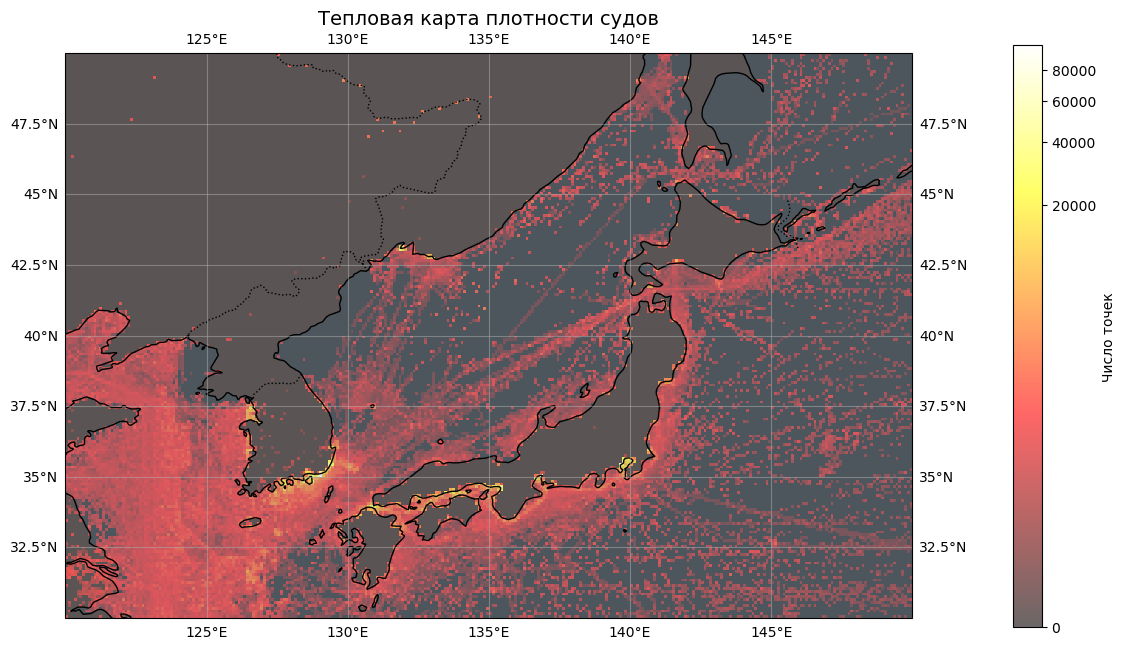

In [180]:
# Суммируем все результаты
heatmap = np.sum(results, axis=0)

# Вычисляем шаг сетки
lat_bins, lon_bins = heatmap.shape
lat_step = (max_lat - min_lat) / lat_bins
lon_step = (max_lon - min_lon) / lon_bins

# Создаем координатную сетку
lats = np.linspace(min_lat, max_lat, lat_bins + 1)
lons = np.linspace(min_lon, max_lon, lon_bins + 1)

# Рисуем график
fig, ax = plt.subplots(figsize=(12, 10),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Отрисовка карты
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, alpha=0.5)

# Отображаем тепловую карту
norm = PowerNorm(gamma=0.2, vmin=heatmap.min(), vmax=heatmap.max())
mesh = ax.pcolormesh(lons, lats, heatmap, cmap='hot', shading='auto', alpha=0.6, norm=norm)

# Цветовая шкала
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.09, shrink=0.6)
cbar.set_label("Число точек")

plt.title("Тепловая карта плотности судов", fontsize=14)
plt.tight_layout()
plt.show()

Обработка батчей c позициями: 100%|██████████| 64/64 [00:04<00:00, 14.82it/s]


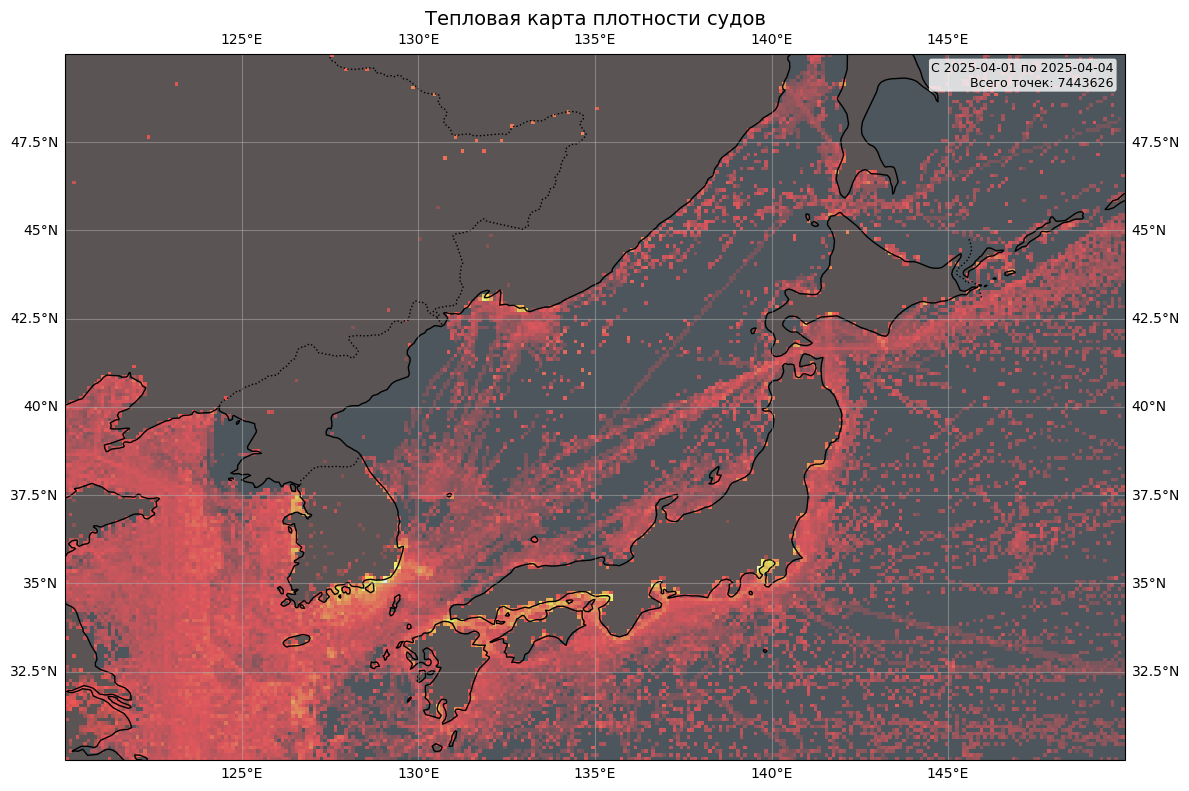

In [260]:
def make_heatmap_frame(h5_path, start_date, end_date, grid_step=0.1, lat=(30, 50), lon=(120, 150), n_workers=8, title="Тепловая карта плотности судов", addinfo=None, frame_path=None):
    # Параметры сетки
    min_lat, max_lat = lat[0], lat[1]
    min_lon, max_lon = lon[0], lon[1]

    # Расчёт размеров сетки
    lat_bins = int((max_lat - min_lat) / grid_step)
    lon_bins = int((max_lon - min_lon) / grid_step)

    wrapped = partial(
        process_batch,
        dataset_path=dataset_path,
        min_lat=min_lat,
        max_lat=max_lat,
        min_lon=min_lon,
        max_lon=max_lon,
        grid_step=grid_step,
        lat_bins=lat_bins,
        lon_bins=lon_bins
    )
    results = process_map(wrapped, make_batch_ranges(dataset_path, start_date, end_date), max_workers=n_workers, desc="Обработка батчей c позициями")

    # Суммируем все результаты
    heatmap = np.sum(results, axis=0)

    # Вычисляем шаг сетки
    lat_bins, lon_bins = heatmap.shape
    lat_step = (max_lat - min_lat) / lat_bins
    lon_step = (max_lon - min_lon) / lon_bins

    # Создаем координатную сетку
    lats = np.linspace(min_lat, max_lat, lat_bins + 1)
    lons = np.linspace(min_lon, max_lon, lon_bins + 1)

    # Рисуем график
    fig, ax = plt.subplots(figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()})

    # Отрисовка карты
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, alpha=0.5)

    # Отображаем тепловую карту
    norm = PowerNorm(gamma=0.2, vmin=heatmap.min(), vmax=heatmap.max())
    mesh = ax.pcolormesh(lons, lats, heatmap, cmap='hot', shading='auto', alpha=0.6, norm=norm)

    # Цветовая шкала
    # cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.09, shrink=0.6)
    # cbar.set_label("Число точек")

    # Доп информация
    if addinfo != None:
        ax.text(
            0.99, 0.01,
            addinfo,
            fontsize=9,
            color='black',
            ha='right',
            va='bottom',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, boxstyle='round,pad=0.2')
        )
    ax.text(
            0.99, 0.95,
            f"С {start_date} по {end_date}\nВсего точек: {np.sum(heatmap)}",
            fontsize=9,
            color='black',
            ha='right',
            va='bottom',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2')
        )

    plt.title(title, fontsize=14)
    plt.tight_layout()
    if frame_path != None:
        plt.savefig(frame_path, bbox_inches='tight', dpi=150)
        plt.close()
    else:
        plt.show()

make_heatmap_frame(dataset_path, "2025-04-01", "2025-04-04")

Обработка батчей c позициями: 100%|██████████| 64/64 [00:03<00:00, 17.46it/s]


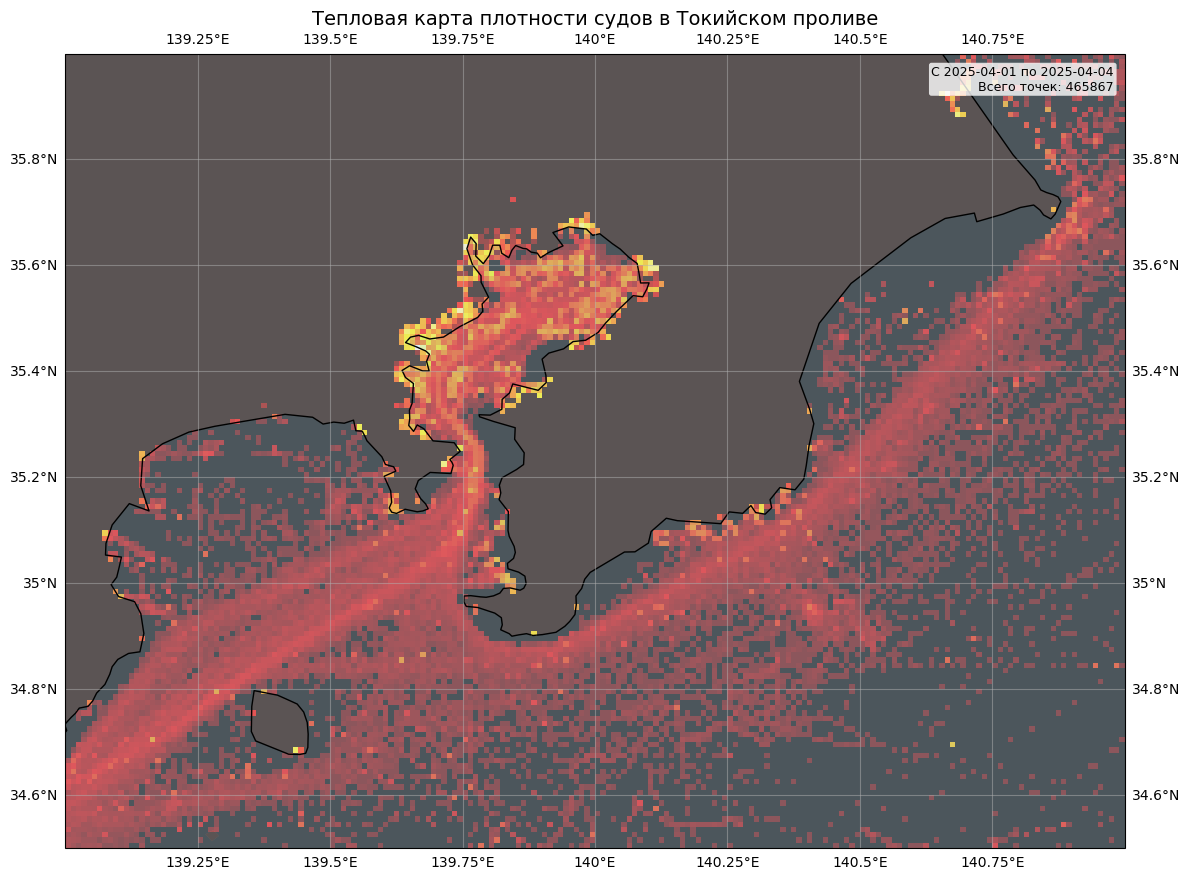

In [222]:
make_heatmap_frame(dataset_path, "2025-04-01", "2025-04-04", lat=(34.5, 36), lon=(139, 141), grid_step=0.01, title="Тепловая карта плотности судов в Токийском проливе")

Обработка батчей c позициями: 100%|██████████| 64/64 [00:03<00:00, 18.81it/s]


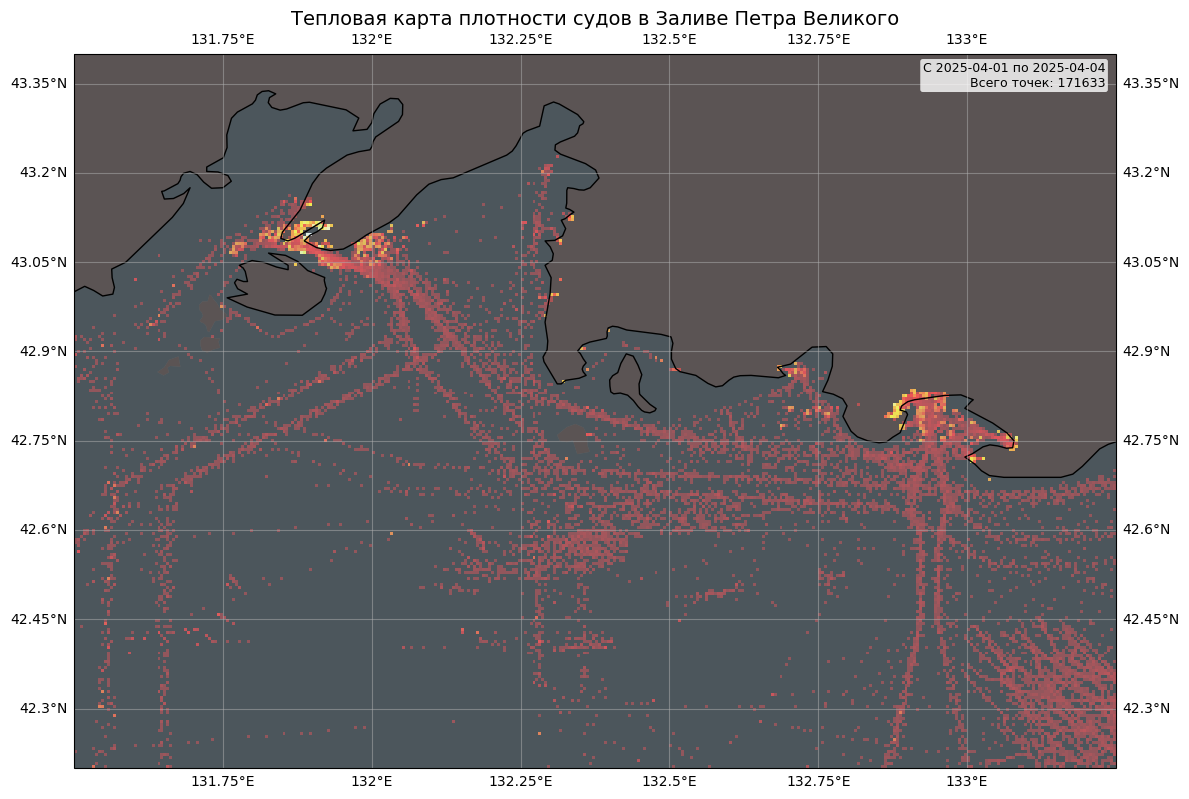

In [223]:
make_heatmap_frame(dataset_path, "2025-04-01", "2025-04-04", lat=(42.2, 43.4), lon=(131.5, 133.25), grid_step=0.005, title="Тепловая карта плотности судов в Заливе Петра Великого")

In [226]:
def split_date_ranges(start_date: str, end_date: str, step_days: int):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    result = []
    current = start
    while current < end:
        range_start = current
        range_end = min(current + timedelta(days=step_days - 1), end)
        result.append((range_start.strftime("%Y-%m-%d"), range_end.strftime("%Y-%m-%d")))
        current = range_end + timedelta(days=1)

    return result

split_date_ranges("2025-01-01", "2025-01-12", 4)

[('2025-01-01', '2025-01-04'),
 ('2025-01-05', '2025-01-08'),
 ('2025-01-09', '2025-01-12')]

In [244]:
output_dir = "output/heatmap_animation_frames_vladivostok"

start = "2025-01-01"
end = "2025-06-01"

dates = split_date_ranges(start, end, 4)

i = 0

for d in dates:
    make_heatmap_frame(dataset_path, d[0], d[1],
                       lat=(42.2, 43.4), lon=(131.5, 133.25),
                       grid_step=0.005,
                       title="Тепловая карта плотности судов в Заливе Петра Великого",
                       frame_path=os.path.join(output_dir, f"frame_{i:04d}.png"),
                       addinfo=f"Анимация с {start} по {end}\nТекущий кадр: {i+1}/{len(dates)}")
    i += 1

Обработка батчей c позициями: 100%|██████████| 64/64 [00:04<00:00, 14.60it/s]


In [247]:
%cd output/heatmap_animation_frames_vladivostok

# Генерируем палитру
!ffmpeg -y -framerate 16 -i frame_%04d.png -vf palettegen palette.png

# Создаем gif с использованием палитры
!ffmpeg -y -framerate 16 -i frame_%04d.png -i palette.png -lavfi paletteuse heatmap_animation_frames_vladivostok.gif

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_vladivostok
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-f

In [276]:
%cd output/heatmap_animation_frames_vladivostok

!ffmpeg -y -framerate 16 -i frame_%04d.png -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p -crf 24 heatmap_animation_frames_vladivostok.mp4

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_vladivostok
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-f

In [242]:
output_dir = "output/heatmap_animation_frames_full"

start = "2025-01-01"
end = "2025-06-01"

dates = split_date_ranges(start, end, 4)

i = 0

for d in dates:
    make_heatmap_frame(dataset_path, d[0], d[1],
                       lat=(30, 50), lon=(120, 150),
                       grid_step=0.1,
                       title="Тепловая карта плотности судов",
                       frame_path=os.path.join(output_dir, f"frame_{i:04d}.png"),
                       addinfo=f"Анимация с {start} по {end} (шаг 4 дня)\nТекущий кадр: {i+1}/{len(dates)}")
    i += 1

Обработка батчей c позициями: 100%|██████████| 64/64 [00:04<00:00, 13.00it/s]


In [243]:
%cd output/heatmap_animation_frames_full

# Генерируем палитру
!ffmpeg -y -framerate 16 -i frame_%04d.png -vf palettegen palette.png

# Создаем gif с использованием палитры
!ffmpeg -y -framerate 16 -i frame_%04d.png -i palette.png -lavfi paletteuse heatmap_animation_frames_full.gif

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_full
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r -

In [275]:
%cd output/heatmap_animation_frames_full

!ffmpeg -y -framerate 16 -i frame_%04d.png -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p -crf 24 heatmap_animation_frames_full.mp4

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_full
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r -

In [246]:
output_dir = "output/heatmap_animation_frames_tokyo"

start = "2025-01-01"
end = "2025-06-01"

dates = split_date_ranges(start, end, 4)

i = 0

for d in dates:
    make_heatmap_frame(dataset_path, d[0], d[1],
                       lat=(34.5, 36), lon=(139, 141),
                       grid_step=0.01,
                       title="Тепловая карта плотности судов в Токийском проливе",
                       frame_path=os.path.join(output_dir, f"frame_{i:04d}.png"),
                       addinfo=f"Анимация с {start} по {end}\nТекущий кадр: {i+1}/{len(dates)}")
    i += 1

Обработка батчей c позициями: 100%|██████████| 64/64 [00:04<00:00, 13.61it/s]


In [248]:
%cd output/heatmap_animation_frames_tokyo

# Генерируем палитру
!ffmpeg -y -framerate 16 -i frame_%04d.png -vf palettegen palette.png

# Создаем gif с использованием палитры
!ffmpeg -y -framerate 16 -i frame_%04d.png -i palette.png -lavfi paletteuse heatmap_animation_frames_tokyo.gif

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_tokyo
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r 

In [274]:
%cd output/heatmap_animation_frames_tokyo

!ffmpeg -y -framerate 16 -i frame_%04d.png -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p -crf 24 heatmap_animation_frames_tokyo.mp4

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_tokyo
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r 

Обработка батчей c позициями: 100%|██████████| 64/64 [00:03<00:00, 18.30it/s]


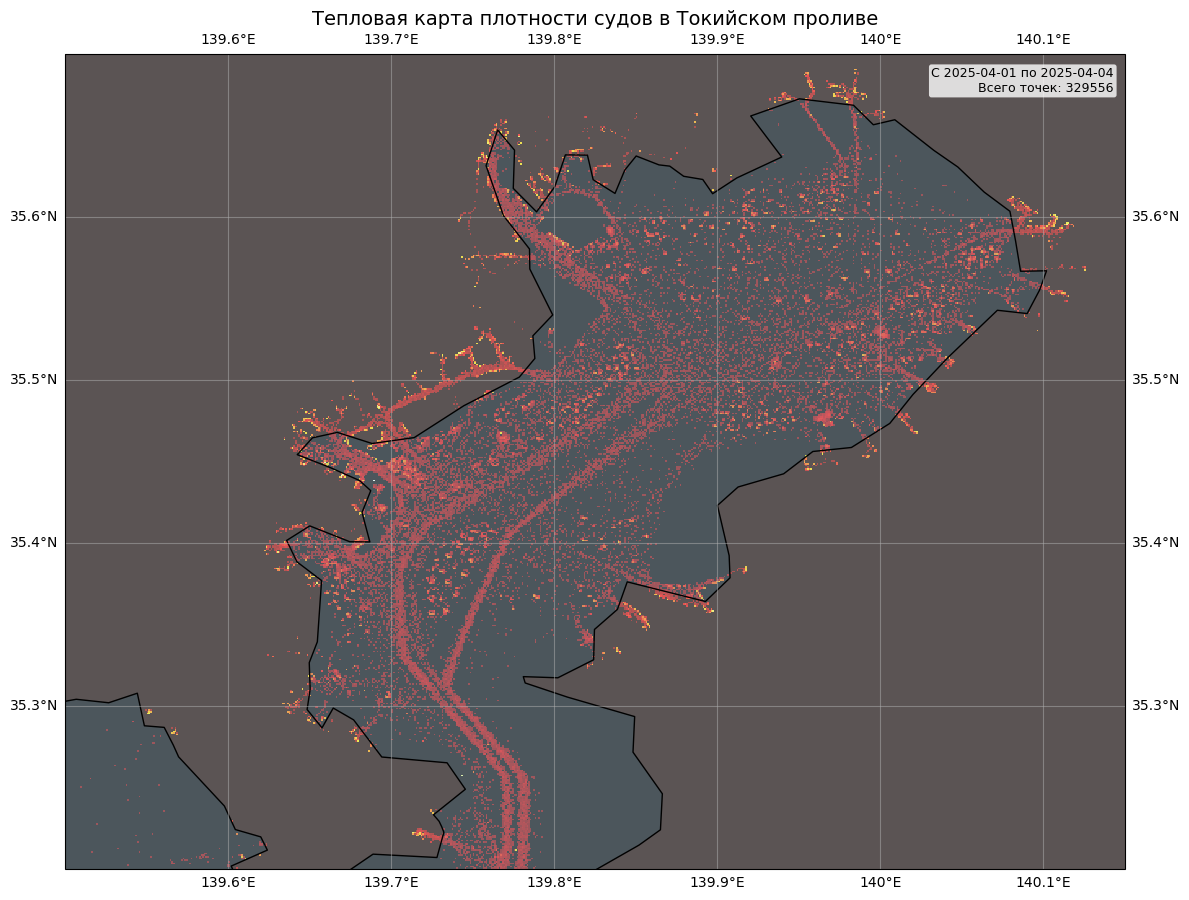

In [261]:
make_heatmap_frame(dataset_path, "2025-04-01", "2025-04-04", lat=(35.2, 35.7), lon=(139.5, 140.15), grid_step=0.001, title="Тепловая карта плотности судов в Токийском проливе")

In [262]:
output_dir = "output/heatmap_animation_frames_tokyo2"

start = "2025-01-01"
end = "2025-06-01"

dates = split_date_ranges(start, end, 4)

i = 0

for d in dates:
    make_heatmap_frame(dataset_path, d[0], d[1],
                       lat=(35.2, 35.7), lon=(139.5, 140.15),
                       grid_step=0.001,
                       title="Тепловая карта плотности судов в Токийском проливе (большой маштаб)",
                       frame_path=os.path.join(output_dir, f"frame_{i:04d}.png"),
                       addinfo=f"Анимация с {start} по {end}\nТекущий кадр: {i+1}/{len(dates)}")
    i += 1

Обработка батчей c позициями: 100%|██████████| 64/64 [00:04<00:00, 13.89it/s]


In [263]:
%cd output/heatmap_animation_frames_tokyo2

# Генерируем палитру
!ffmpeg -y -framerate 16 -i frame_%04d.png -vf palettegen palette.png

# Создаем gif с использованием палитры
!ffmpeg -y -framerate 16 -i frame_%04d.png -i palette.png -lavfi paletteuse heatmap_animation_frames_tokyo2.gif

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_tokyo2
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r

In [267]:
%cd output/heatmap_animation_frames_tokyo2

!ffmpeg -y -framerate 16 -i frame_%04d.png -c:v libx264 -pix_fmt yuv420p -crf 24 heatmap_animation_frames_tokyo2.mp4

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/heatmap_animation_frames_tokyo2
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r